# Detecting Dwarf Galaxies: The Performance & Limitations of Various Density Estimators

### Nicolas Garavito, Jennifer Kadowaki, Matt Kirby, Ben Lew, Ragadeepika Pucha

References:
- ASTR 502 Lecture 9
- ASTR 502 Lecture 10
- Willman+2005 - A New Milky Way Dwarf Galaxy in Ursa Major
- Willman+2002 - An SDSS Survey for Resolved Milky Way Satellite Galaxies. I. Detection Limits
- McConnachie+2012 - The Observed Properties of Dwarf Galaxies in and around Local Group
- CasJobs

## Dwarf Galaxies - Why are they important?

- The $\Lambda$-CDM model of structure formation has many issues in the low-mass scales: The Missing Satellites Problem, Too Big to Fail Problem.
- Study of Dwarf Galaxies will help in solving these problems.
- Dwarf Galaxies are building blocks of galaxy formation and evolution.
- Study of Environmental factors in the growth of galaxies.
- Study of Reionization in the growth of galaxies.

## Detection of Dwarf Galaxies

- Before SDSS, only a few dwarf galaxies were known. 
- SDSS revolutionized the field with the detection of more and more dwarf galaxies - especially ultra-faint galaxies.
- Depth of SDSS (~24 mag). The upcoming large surveys (LSST) are going to map the sky much deeper - Need some method to detect dwarf galaxies.
- The easiest direct method is finding over-densities of resolved stars.

## Outline of the Project

- Getting SDSS data of known dwarf galaxies using SQL queries.
- Applying Different Density Estimators to each of them.
- Applying the Different Estimators to simulated data.
- Conclusions

## Getting the SDSS Data - 

- SQL Query : 
```SQL
SELECT
    p.ra, p.dec, p.psfMag_g, psfMagErr_g, p.psfMag_r, p.psfMagErr_r, p.psfMag_i, p.psfMagErr_i
FROM PhotoObjAll AS p
WHERE
    p.ra BETWEEN 150.77 AND 152.77
    AND p.dec BETWEEN 15.08 AND 17.08
    AND dbo.fDistanceArcMinEq(151.77, 16.08, p.ra, p.dec) < 30.
    AND p.clean = 1
```
- Dwarf Galaxies Considered - 
    * Leo II ($M_{V}$ = -9.8, $r_{h}$ = 176 pc, ${\mu}_{V}$ = 24.2)
    * Draco ($M_{V}$ = -8.8, $r_{h}$ = 221 pc, ${\mu}_{V}$ = 25.0)
    * Willman I ($M_{V}$ = -2.7, $r_{h}$ = 25 pc, ${\mu}_{V}$ = 26.1)
    * Segue ($M_{V}$ = -1.5, $r_{h}$ = 29 pc, ${\mu}_{V}$ = 27.6)

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
import sys
from numpy.random import random, exponential, randint
from astropy.table import Table
import os
import errno
import numpy as np
from astroML.density_estimation import KDE, KNeighborsDensity
from sklearn.neighbors import KernelDensity

In [3]:
sys.path.append('../code/')
import density_functions
from density_tools import density_peaks

In [4]:
font = {'size':18, 'family':'serif'}
matplotlib.rc('font', **font)

In [5]:
## reading the data
def read_data(data):
    """
    Reads the fits data   """
    h = fits.open(data)
    t = h[1].data
    ra = t['ra']
    dec = t['dec']
    return ra, dec

In [6]:
sdss_data = ['leo2.fits', 'draco.fits', 'willman1.fits', 'segue.fits']
gal_name = ['Leo II', 'Draco', 'Willman I', 'Segue' ]

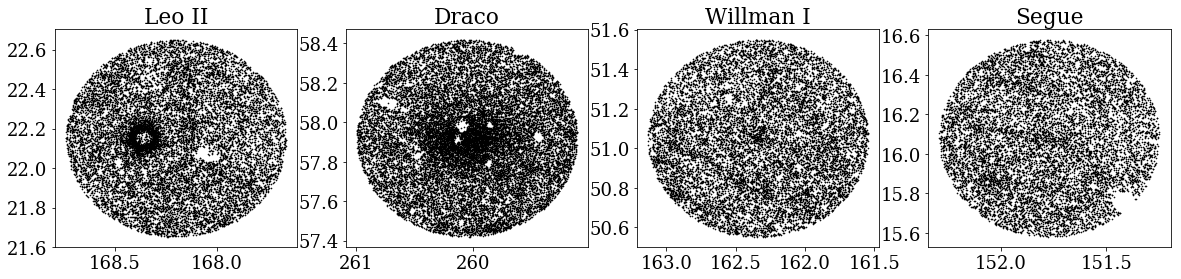

In [6]:
plt.figure(figsize = (20, 4))
k=0
for name in sdss_data:
    ra, dec = read_data('../data/sdss_fields/'+name)
    plt.subplot2grid((1,4), (0,k))
    plt.title(gal_name[k])
    
    plt.scatter(ra, dec, c = 'k', s = 0.4)
    plt.gca().invert_xaxis()
    
    k+=1

## Various Density Estimators - 

- Nearest Neighbor Density Estimator
- Kernel Density Estimator (Gaussian Kernels)
- Kernel Density Estimator (Top-Hat Kernels)
- Kernel Density Estimator (Exponential Kernels)
- Gaussian Mixture Model
- Two-point Correlation Funtion

In [7]:
## 

def overdensities(dens, sigma_min, sigma_max, xmin=0, xmax=1, ymin=0, ymax=1):
    # Defining grid
    x = np.linspace(xmin, xmax, np.shape(dens)[0])
    y = np.linspace(ymin, ymax, np.shape(dens)[1])
    X, Y = np.meshgrid(x, y)

    # Defining sigma as the standard deviation of the data
    sigma = np.std(dens.flatten())
    # Finding the median of the all the data in the field
    dens_median = np.median(dens.flatten())
    # Defining the contours range.·
    overdensities = []
    color_bar_labels = []

    for i in range(sigma_min, sigma_max+1):
        overdensities.append(dens_median + i*sigma)
        color_bar_labels.append(str(i) + '$\sigma$')
    #print(color_bar_labels)
    
    return X, Y, overdensities, color_bar_labels

## Nearest Neighbour Density Estimator 

In [8]:
def NN_bayesian_density(x, y, NN, grid_size):
    """
    Function to compute the density of a distribution of particles
    using the K-Nearest Neighboors
    method from:
    http://www.astroml.org/modules/generated/astroML.density_estimation.KNeighborsDensity.html#astroML.density_estimation.KNeighborsDensity
    See Ivezic 10? for the details on how the algorithm works.

    Input:
    ------
    x : 1D numpy.array
        Array with the x-coordinates of the data.
    y : 1D numpy.array
        Array with the y-coordinates of the data.
    NN : int
        Number of neighboors to compute the desnity.
    grid_size : int
        Grid size in which the density is going to be evaluated.

    """
    assert len(x)==len(y), "Input data have different size"
    assert type(NN) == int, "NN should be of type int"
    assert type(grid_size) == int, "grid_zise should be of type int"

    # Grid parameters
    Nx = grid_size
    Ny = grid_size
    xmin, xmax = (min(x), max(x))
    ymin, ymax = (min(y), max(y))

    # Making a grid
    Xgrid = np.vstack(map(np.ravel, np.meshgrid(np.linspace(xmin, xmax, Nx),\
                                                np.linspace(ymin, ymax, Ny)))).T
    # Putting data in 2d-array
    X = np.array([x, y]).T

    # Computing the density
    knn = KNeighborsDensity('bayesian', NN)
    dens_KNN = knn.fit(X).eval(Xgrid).reshape((Ny, Nx))

    return dens_KNN

/Users/ragadeepika.pucha/anaconda/lib/python3.6/site-packages/matplotlib/colorbar.py:215: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")


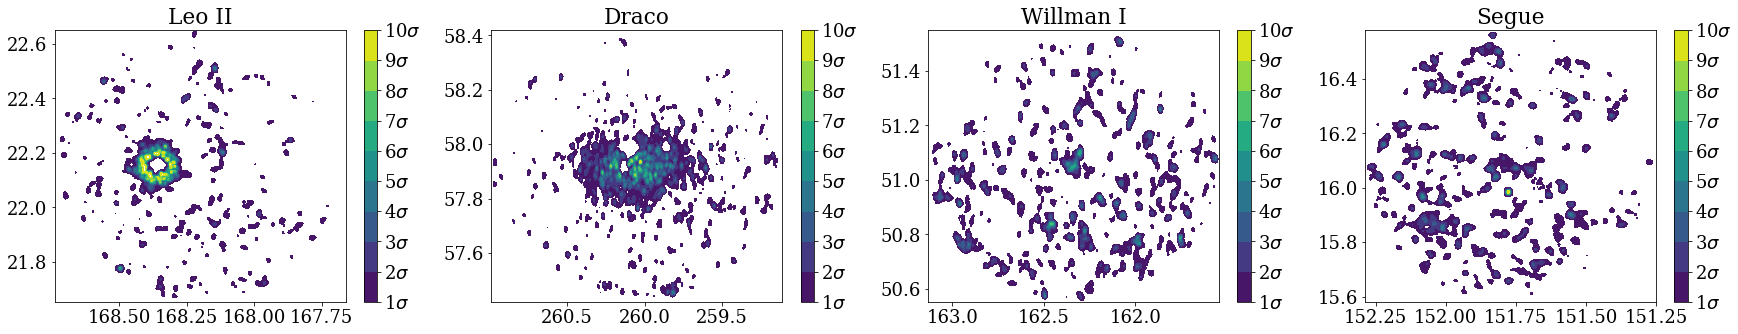

In [9]:
plt.figure(figsize = (30, 5))
k=0
for name in sdss_data:
    ra, dec = read_data('../data/sdss_fields/'+name)
    dens_field_NN = NN_bayesian_density(ra, dec, 20, 500)
    
    X_NN, Y_NN, overdens_NN, colorbar_NN = overdensities(dens_field_NN, 1, 10, xmin=min(ra), xmax=max(ra), ymin=min(dec), ymax=max(dec))
    plt.subplot2grid((1,4), (0, k))
    plt.title(gal_name[k])
    plt.contourf(X_NN, Y_NN, dens_field_NN, overdens_NN)
    cbar = plt.colorbar()
    cbar.ax.set_yticks(np.arange(0, len(colorbar_NN)+1, 1))
    cbar.ax.set_yticklabels(colorbar_NN)
    plt.gca().invert_xaxis()
    
    k+=1
    

# Kernel Density Estimator

In [10]:
def KDE(ra, dec, kernel = 'gaussian'):
    """
    Compute the Kernel Density Estimators (KDE) from scikit learn

    Input:
    -----

    x : 1D numpy.array
        Array with the x-coordinates of the data.
    y : 1D numpy.array
        Array with the y-coordinates of the data.
    kernel : str
        Optional kernel: gaussian (default), tophat, exponential

    Output:
    -------

    dens : numpy.array 
        2d array with the density estimation

    """


    ramin = min(ra)
    ramax = max(ra)
    decmin = min(dec)
    decmax = max(dec)

    x, y = np.mgrid[ramin:ramax:300j, decmin:decmax:300j]
    Xgrid = np.vstack([x.ravel(), y.ravel()]).T

    values = np.vstack([ra, dec])
    X = values.T

    kde1 = KernelDensity(0.01, kernel=kernel)
    log_dens1 = kde1.fit(X).score_samples(Xgrid)
    dens1 = X.shape[0] * np.exp(log_dens1).reshape((300,300))

    return (dens1.T)

## Gaussian Kernel


/Users/ragadeepika.pucha/anaconda/lib/python3.6/site-packages/matplotlib/colorbar.py:215: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")


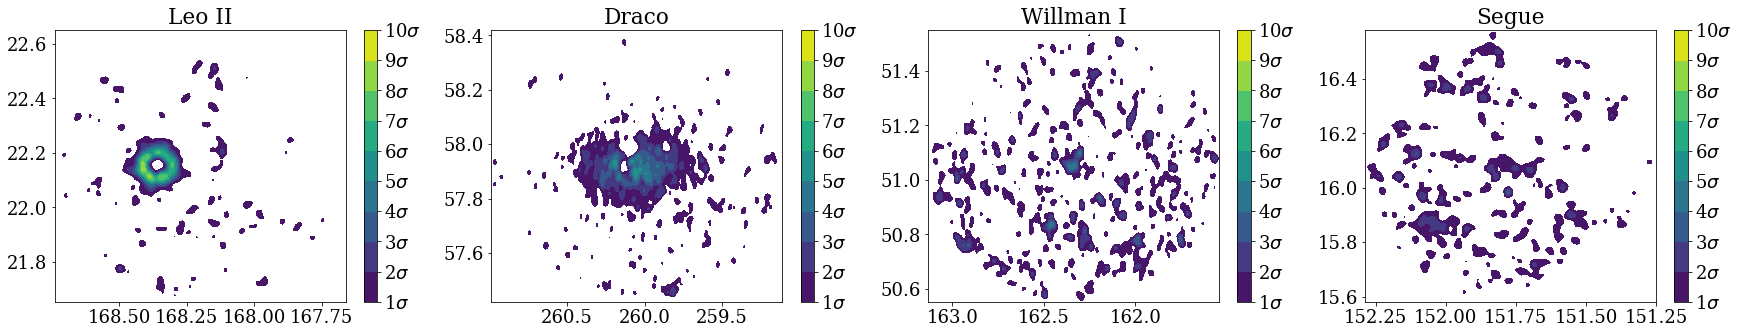

In [11]:
plt.figure(figsize = (30, 5))
k=0
for name in sdss_data:
    ra, dec = read_data('../data/sdss_fields/'+name)
    dens_field_KDE_gaussian = KDE(ra,dec, kernel = 'gaussian')
    
    X_KDE_gaussian, Y_KDE_gaussian, overdens_KDE_gaussian, colorbar_KDE_gauss = overdensities(dens_field_KDE_gaussian, 1, 10, xmin=min(ra), xmax=max(ra), ymin=min(dec), ymax=max(dec))    
    plt.subplot2grid((1,4), (0, k))
    plt.title(gal_name[k])
    plt.contourf(X_KDE_gaussian, Y_KDE_gaussian, dens_field_KDE_gaussian, overdens_KDE_gaussian)
    plt.gca().invert_xaxis()
    cbar = plt.colorbar()
    cbar.ax.set_yticks(np.arange(0, len(colorbar_KDE_gauss)+1, 1))
    cbar.ax.set_yticklabels(colorbar_KDE_gauss)
    
    k+=1

## Top-Hat Kernel

/Users/ragadeepika.pucha/anaconda/lib/python3.6/site-packages/matplotlib/colorbar.py:215: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")


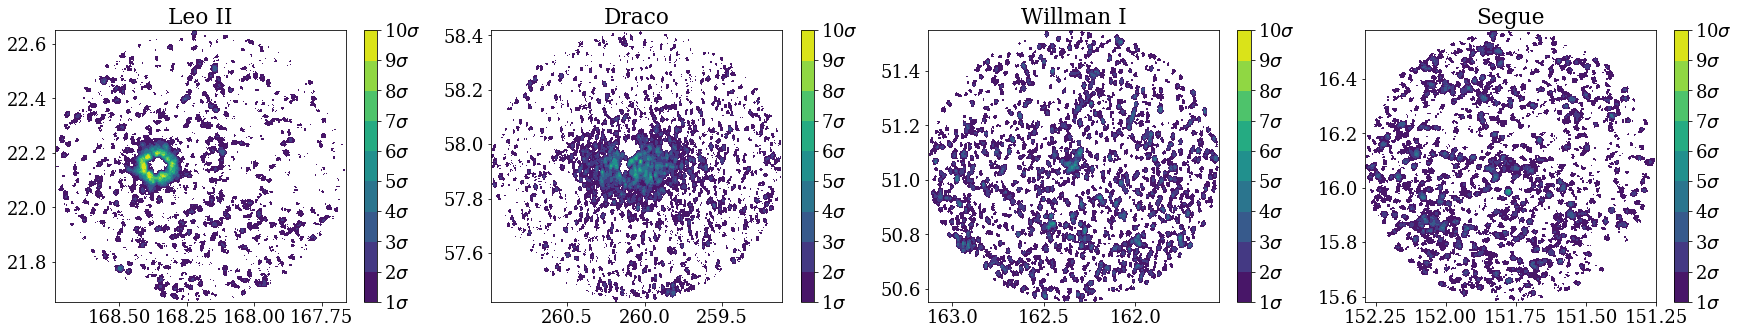

In [32]:
plt.figure(figsize = (30, 5))
k=0
for name in sdss_data:
    ra, dec = read_data('../data/sdss_fields/'+name)
    dens_field_KDE_th = KDE(ra,dec, kernel = 'tophat') 
    
    X_KDE_th, Y_KDE_th, overdens_KDE_th, colorbar_KDE_th = overdensities(dens_field_KDE_th, 1, 10, xmin=min(ra), xmax=max(ra), ymin=min(dec), ymax=max(dec))
    plt.subplot2grid((1,4), (0, k))
    plt.title(gal_name[k])
    plt.contourf(X_KDE_th, Y_KDE_th, dens_field_KDE_th, overdens_KDE_th)
    plt.gca().invert_xaxis()
    cbar = plt.colorbar()
    cbar.ax.set_yticks(np.arange(0, len(colorbar_KDE_th)+1, 1))
    cbar.ax.set_yticklabels(colorbar_KDE_th)
    
    k+=1

## Exponential Kernels

/Users/ragadeepika.pucha/anaconda/lib/python3.6/site-packages/matplotlib/colorbar.py:215: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")


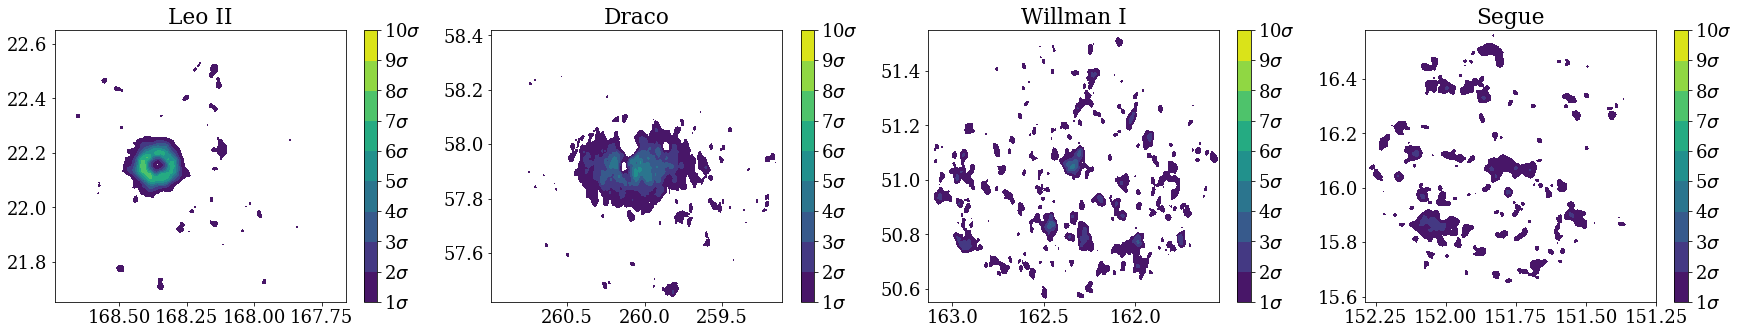

In [33]:
plt.figure(figsize = (30, 5))
k=0
for name in sdss_data:
    ra, dec = read_data('../data/sdss_fields/'+name)
    dens_field_KDE_exponential = KDE(ra,dec, kernel = 'exponential')
    
    X_KDE_exp, Y_KDE_exp, overdens_KDE_exp, colorbar_KDE_exp = overdensities(dens_field_KDE_exponential, 1, 10, xmin=min(ra), xmax=max(ra), ymin=min(dec), ymax=max(dec))    
    plt.subplot2grid((1,4), (0, k))
    plt.title(gal_name[k])
    plt.contourf(X_KDE_exp, Y_KDE_exp, dens_field_KDE_exponential, overdens_KDE_exp)
    plt.gca().invert_xaxis()
    cbar = plt.colorbar()
    cbar.ax.set_yticks(np.arange(0, len(colorbar_KDE_exp)+1, 1))
    cbar.ax.set_yticklabels(colorbar_KDE_exp)
    
    
    k+=1
    

## Comparison of Different Estimators

/Users/ragadeepika.pucha/anaconda/lib/python3.6/site-packages/matplotlib/colorbar.py:215: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")


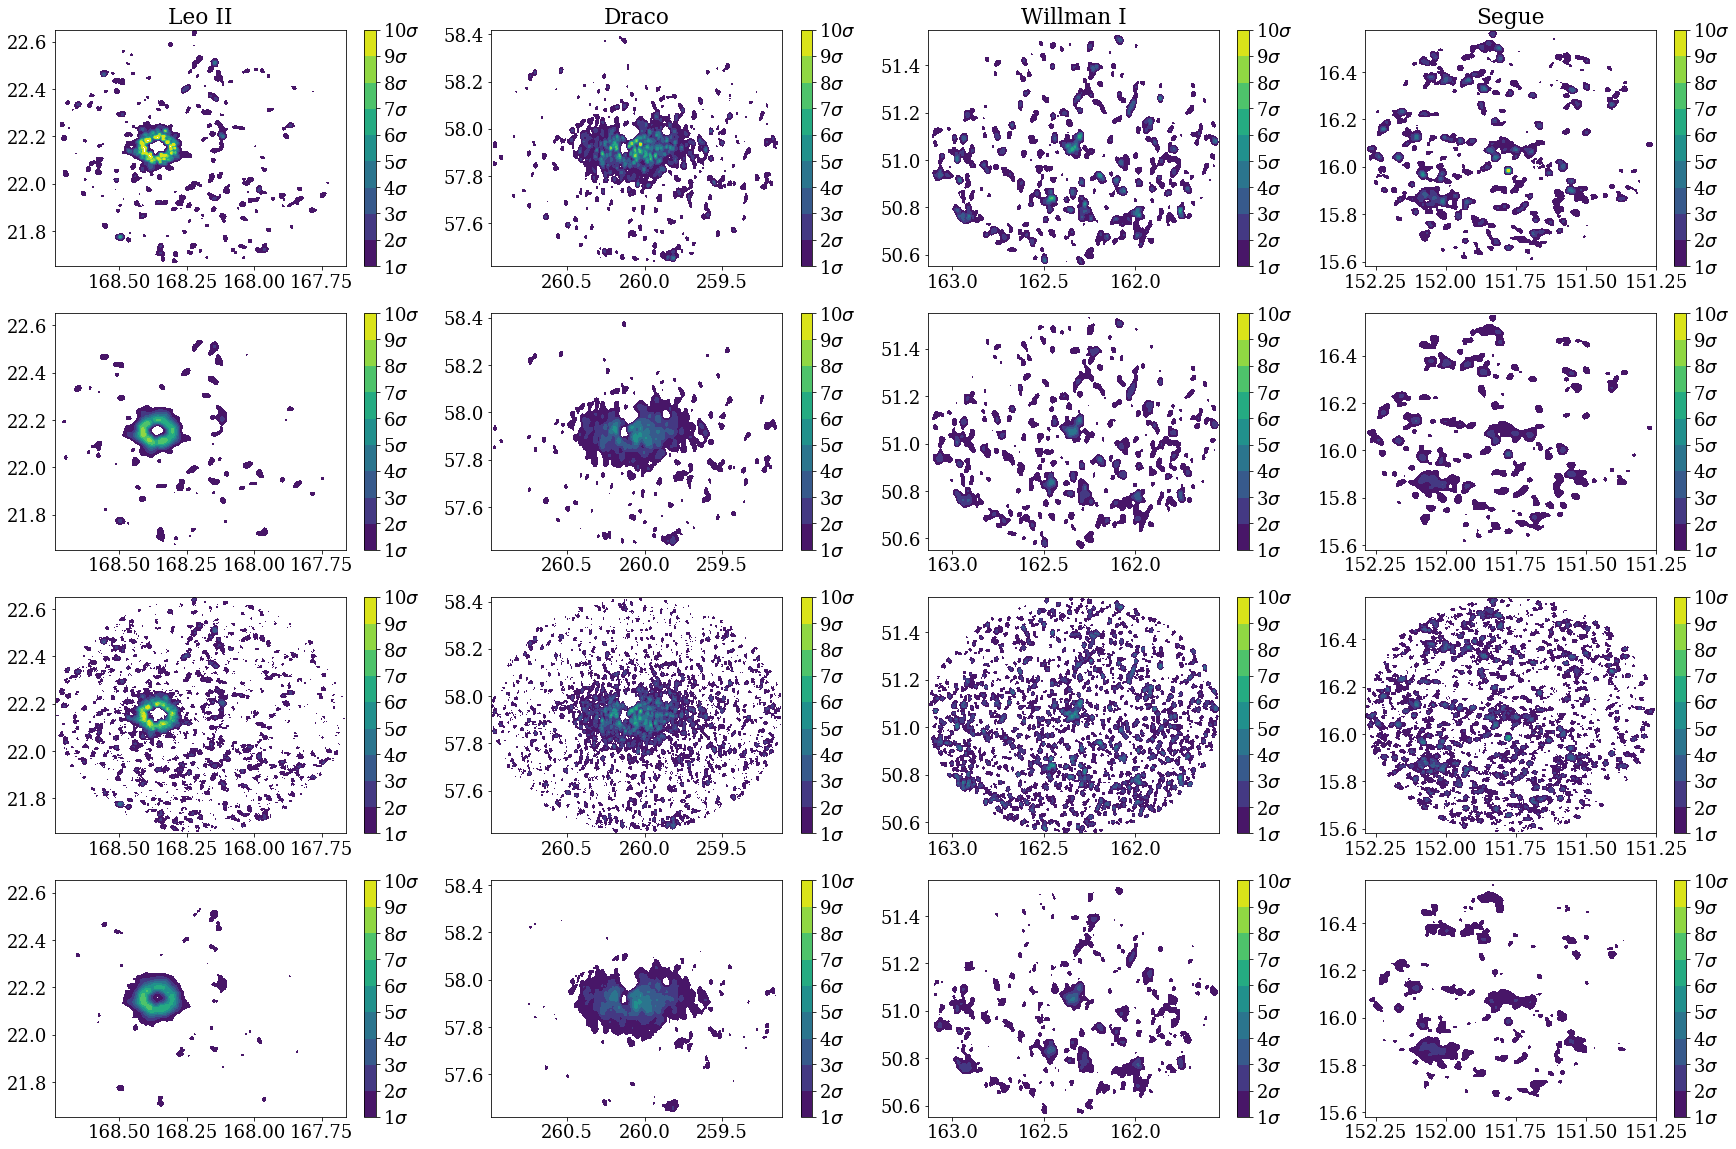

In [34]:
plt.figure(figsize = (30, 20))
k=0

for name in sdss_data:
    ra, dec = read_data('../data/sdss_fields/'+name)
    dens_field_KDE_exponential = KDE(ra,dec, kernel = 'exponential')
    dens_field_KDE_th = KDE(ra,dec, kernel = 'tophat') 
    dens_field_KDE_gaussian = KDE(ra,dec, kernel = 'gaussian')
    dens_field_NN = NN_bayesian_density(ra, dec, 20, 500)
    
    X_NN, Y_NN, overdens_NN, colorbar_NN = overdensities(dens_field_NN, 1, 10, xmin=min(ra), xmax=max(ra), ymin=min(dec), ymax=max(dec))  
    X_KDE_gaussian, Y_KDE_gaussian, overdens_KDE_gaussian, colorbar_KDE_gauss = overdensities(dens_field_KDE_gaussian, 1, 10, xmin=min(ra), xmax=max(ra), ymin=min(dec), ymax=max(dec))    
    X_KDE_th, Y_KDE_th, overdens_KDE_th, colorbar_KDE_th = overdensities(dens_field_KDE_th, 1, 10, xmin=min(ra), xmax=max(ra), ymin=min(dec), ymax=max(dec))
    X_KDE_exp, Y_KDE_exp, overdens_KDE_exp, colorbar_KDE_exp = overdensities(dens_field_KDE_exponential, 1, 10, xmin=min(ra), xmax=max(ra), ymin=min(dec), ymax=max(dec))    

    plt.subplot2grid((4,4), (0, k))
    plt.title(gal_name[k])
    plt.contourf(X_NN, Y_NN, dens_field_NN, overdens_NN)
    plt.gca().invert_xaxis()
    cbar = plt.colorbar()
    cbar.ax.set_yticks(np.arange(0, len(colorbar_NN)+1, 1))
    cbar.ax.set_yticklabels(colorbar_NN)
    
    plt.subplot2grid((4,4), (1, k))
    plt.contourf(X_KDE_gaussian, Y_KDE_gaussian, dens_field_KDE_gaussian, overdens_KDE_gaussian)
    plt.gca().invert_xaxis()
    cbar = plt.colorbar()
    cbar.ax.set_yticks(np.arange(0, len(colorbar_KDE_gauss)+1, 1))
    cbar.ax.set_yticklabels(colorbar_KDE_gauss)
    
    
    plt.subplot2grid((4,4), (2, k))
    plt.contourf(X_KDE_th, Y_KDE_th, dens_field_KDE_th, overdens_KDE_th)
    plt.gca().invert_xaxis()
    cbar = plt.colorbar()
    cbar.ax.set_yticks(np.arange(0, len(colorbar_KDE_th)+1, 1))
    cbar.ax.set_yticklabels(colorbar_KDE_th)
    
    plt.subplot2grid((4,4), (3, k))
    plt.contourf(X_KDE_exp, Y_KDE_exp, dens_field_KDE_exponential, overdens_KDE_exp)
    plt.gca().invert_xaxis()
    cbar = plt.colorbar()
    cbar.ax.set_yticks(np.arange(0, len(colorbar_KDE_exp)+1, 1))
    cbar.ax.set_yticklabels(colorbar_KDE_exp)
    k+=1
    

In [7]:
sigmas_NN = [9, 6, 4, 4]
sigmas_KDE_gauss = [7, 4, 3, 2]
sigmas_KDE_th = [8, 5, 4, 4]
sigmas_KDE_exp = [6,4, 3, 2]

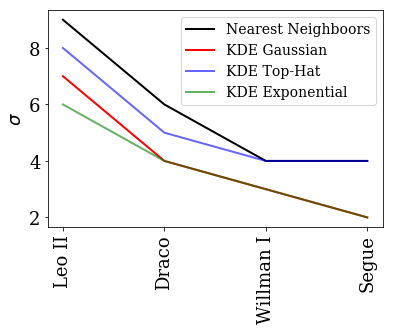

In [8]:
fig, ax = plt.subplots(1,1) 
ax.plot(np.arange(0, 4), sigmas_NN, c='k', label='Nearest Neighboors', lw=2)
ax.plot(np.arange(0, 4), sigmas_KDE_gauss, c='r',  label='KDE Gaussian', lw=2)
ax.plot(np.arange(0, 4), sigmas_KDE_th, c='b', alpha=0.6, label='KDE Top-Hat', lw=2)
ax.plot(np.arange(0, 4), sigmas_KDE_exp, c='g', alpha=0.6, label='KDE Exponential', lw=2)
ax.set_ylabel(r'$\sigma$')
ax.legend(fontsize=14)
x_ticks_labels = ['', 'Leo II','Draco', 'Willman I','Segue']
ax.set_xticklabels(x_ticks_labels, rotation='vertical', fontsize=18)


## Modified Gaussian Mixture Model (GMM)

GMM models' fundamental assumption: Gaussian distribution
A uniform background in addition to GMM : **pyGMMis** 
https://github.com/pmelchior/pygmmis
https://arxiv.org/pdf/1611.05806.pdf

**Assumptions/Input:**
number of components:2 \\
covergence threshold:1e-7 \\
initial models: Simple GMM models\\
background maximum fraction: 0.999 \\
background fraction:0.9 \\
completeness: 1 for inside ellipse, 0 for outside of ellipse \\
oversampling for missing data: 100 \\
positional uncertainties: 0.01 deg \\

**Error Estimation**
Simulate a gaussian with 1000points, $\sigma$=0.1 in both RA and DEC direction. True positive is calculated by how many times in 50 iterations the injected gaussian is detected within 3 sigma from the fitted center.



**Example code: Draco**

In [18]:
#import pygmmis and parmap by
#  pip install git+https://github.com/pmelchior/pygmmis.git
# Written by Ben Lew on Dec 2nd, 2017
# wplew@lpl.arizona.edu
import pygmmis
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
import matplotlib.cm
import datetime
from functools import partial
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from astroML.decorators import pickle_results
from astroML.plotting.tools import draw_ellipse
import scipy as scipy
from matplotlib.patches import Ellipse
from numpy.random import RandomState
from astroML.density_estimation import XDGMM

def in_ellipse(x,y,a,b,alpha,datax,datay):
#https://stackoverflow.com/questions/7946187/point-and-ellipse-rotated-position-test-algorithm
    a=a*3
    b=b*3
    first=  (np.cos(alpha)*(datax-x)+np.sin(alpha)*(datay-y))**2/a**2 
    second= (np.sin(alpha)*(datax-x)+np.cos(alpha)*(datay-y))**2/b**2 
    print  (alpha,first +second)
    print (first+second < 1)
    return (first+second) < 1  
hdulist = fits.open('../data/sdss_fields/draco.fits')
# hdulist = fits.open('../data/mock_fields/background/background_0.5_1000_0.15_10000.fits')

tbdata = hdulist[1].data
cols = hdulist[1].columns
ra=tbdata['ra']
dec=tbdata['dec']

meanra=np.mean(ra)
meandec=np.mean(dec)
rar=max(ra)-meanra
decr=max(dec-meandec)
def cb(coords):
    a=rar
    b=decr
    normra=coords[:,0]-meanra
    normdec=coords[:,1]-meandec
    return ((normra/a)**2+(normdec/b)**2 <1 )
    
K = 2               # number of components
D=2                 # Data dimensionality
data=np.asarray((ra,dec)).T
print ("data",data.shape, cb(data))
# seed = 42
niter=50
centerlist=[]
alphalist=[]
alist=[]
blist=[]
randcenterlist=[]
realcenter=[meanra,meandec]
maxL=-100

origra=ra
origdec=dec
simamp=1
gaussnum=1000

for j in range(niter):
    # simulate fake gaussian
    rand=int(np.random.rand(1)*len(ra))
    randcenter=[ra[rand],dec[rand]]
    simcov=np.diagflat([0.1,0.1])/simamp
    simgauss= np.random.multivariate_normal(randcenter,simcov,gaussnum)
    randcenterlist.append(randcenter)
    # print "simgauss",simgauss.shape
    # plt.scatter(simgauss[:,0],simgauss[:,1])
    # plt.show()

    ra= np.concatenate((origra,simgauss[:,0]))
    dec=np.concatenate((origdec,simgauss[:,1]))

    # ----------------gmm initialization----------------
    gmm = pygmmis.GMM(K=K, D=D)
    data = pygmmis.createShared(data)

    # positional uncertainties    
    dispersion = .01
    default_covar = np.eye(D) * dispersion**2
    covar_cb = partial(pygmmis.covar_callback_default, default=default_covar)

    
    #background    
    footprint = data.min(axis=0), data.max(axis=0)
    bg = pygmmis.Background(footprint)
    bg.amp = 0.95
    bg.amp_max = 0.999
    bg.adjust_amp = True

    #run the fitter
    w = 0.1    # minimum covariance regularization, same units as data
    cutoff = 1.5 # segment the data set into neighborhood within cutoff* sigma around components
    tol = 1e-9 # tolerance on logL to terminate EM
    pygmmis.VERBOSITY = 2      # 0,1,2
    pygmmis.OVERSAMPLING = 100  # number of imputation samples per data sample

    # define RNG for deterministic behavior
    rng = RandomState()

    # run EM
    # print "before fit",gmm.mean
    logL, U = pygmmis.fit(gmm, data, init_callback=pygmmis.initFromSimpleGMM,\
                          sel_callback=cb, covar_callback=covar_cb, w=w, cutoff=cutoff,\
                          background=bg, tol=tol, rng=rng)
    falselist=np.where(U[0]==False)[0]
    truelist=np.where(U[0]==True)[0]

    # print "num of U==true", len(truelist)*1.0/len(U[0])
    print (logL)
    if logL > maxL:
        bestgmm=gmm
        maxL=logL
    size = 100

    color=["red","green","magenta","black","blue","orange"]

    for i in range(K):
        centerlist.append(gmm.mean[i])
        cov=gmm.covar
        eigval,eigvec=np.linalg.eig(cov[i])
        argsort=np.argsort(eigval)
        eigvec=eigvec[argsort]
        eigval=eigval[argsort]
        a,b=eigval[0],eigval[1]
        alpha=np.arctan(eigvec[1,0]/eigvec[0,0])
        
        alphalist.append(alpha)
        alist.append(a)
        blist.append(b)
        

# plotgraph=111
fig = plt.figure(figsize=(5, 5))

ax = fig.add_subplot(111)
# ax.patch.set_facecolor('purple')

for i in range(K):
    sigma_x = bestgmm.mean[0,0]
    sigma_y = bestgmm.mean[0,1]

    cov=bestgmm.covar
    eigval,eigvec=np.linalg.eig(cov[i])
    argsort=np.argsort(eigval)
    eigvec=eigvec[argsort]
    eigval=eigval[argsort]
    a,b=eigval[0],eigval[1]
    center=bestgmm.mean[i]
    amp=bestgmm.amp[i]
    # centerlist.append(center)


    alpha=np.arctan(eigvec[1,0]/eigvec[0,0])
    print ("amp 1 and 2",color[i],amp)
    print ("a,b,center",eigvec.shape)
    x = np.linspace(center[0]-2*a, center[0]+2*a, num=size)
    y = np.linspace(center[1]-2*a, center[1]+2*a, num=size)

    x, y = np.meshgrid(x, y)
    z = (1/(2*np.pi*a*b) * np.exp(-(x**2/(2*a**2)
         + y**2/(2*b**2))))
    plt.contourf(x, y, z,alpha=0.0)

    for N in (1,2,3):
        ax.add_patch(Ellipse(center, N * a, N * b,
                                 angle=alpha * 180. / np.pi, lw=1,
                                 ec='red', fc='none'))
# plt.colorbar()
# count how many detect injected gaussian within 1-sigmna#

count=0
centerlist=np.asarray(centerlist)
print ("real center",realcenter)
for p in range(niter):
    print (p, "iter:")
    randcenter=randcenterlist[p]
    if (in_ellipse(randcenter[0],randcenter[1],alist[p*K],blist[p*K],alphalist[p*K],centerlist[p*K,0],centerlist[p*K,1])) or \
        (in_ellipse(randcenter[0],randcenter[1],alist[p*K+1],blist[p*K+1],alphalist[p*K+1],centerlist[p*K+1,0],centerlist[p*K+1,1])):
        count+=1
        
   
plt.title("GMM for Draco +injected gauss pts="+str(gaussnum)+", amp="+str(simamp)+"\n True Positive:"+str(1.0*count/niter))
plt.scatter(data[:,0],data[:,1],s=0.4,label="data")
# plt.scatter(randcenter[0],randcenter[1],marker="x",s=100,color='k',label="injected Gaussian")
# plt.scatter(data[U[1],0],data[U[1],1],s=0.5)
# plt.scatter(data[falselist,0],data[falselist,1],s=0.5,alpha=0.5)
# plt.scatter(data[U[1],0],data[U[1],1],s=0.5,alpha=0.5,color="red")
# fig2=plt.figure()
# ax2 = fig2.add_subplot(111)
#
plt.scatter(centerlist[:,0],centerlist[:,1],marker="o",color="green",alpha=0.4,label="best-fit center")
print ("center shape", centerlist.shape)
print ("centerlist ra",centerlist[:,0])
# H, xedges, yedges= np.histogram2d(centerlist[:,0], centerlist[:,1], bins=6, range=None, normed=False, weights=None)
# X, Y = np.meshgrid(xedges, yedges)
# cap=ax2.pcolormesh(X, Y, H)
# plt.colorbar(cap)
plt.legend()

plt.show()



SyntaxError: Missing parentheses in call to 'print' (pygmmis.py, line 454)

**Result:**

<img src="images/gmm_draco.png" style="width: 300px;"/>|<img src="images/GMM_leo2.png" style="width: 300px;"/> 
<img src="images/GMM_segue.png" style="width: 300px;"/ >|<img src="images/GMM_willman1.png" style="width: 300px;"/>  
Based on the fitted result it seems that mGMM fits well but its intiall parameters maybe bias to the center.

The true detection rate is around 30%-- this is likely because of the local minima. 50 iterations takes about 5 minutes so in principle local minima can be avoided by running more iterations with random intial parameters.



## Testing Density Estimation Methods with Simulated Data
We implement each algorithm on synthetic dwarfs to obtain measurements of performance and robustness.

- ### Sample Completeness
  - What parameter space are we no longer detecting dwarf galaxies?


- ### Spurious Source Fraction
  - Are we detecting stellar overdensities in the background of fields containing dwarfs and in fields containing no dwarfs?
  - What parameter space are we prone to false positives?

## Simulated Data
Simulated data is composed of:
- ### Background Point Sources
  A uniformly random sample of background point sources (of varying crowdedness)
  - Background Densities: 10000, 15000, and 20000 stars / square degree.


- ### Stars in Dwarf Galaxy
  A randomly sampled exponential profile of stars in the dwarf galaxy (of varying numbers and scale lengths).
  - Number of Stars in Dwarf: 100, 500, 1000, and 5000 stars
  - Scale Lengths of Dwarf: 0.1, 0.15, 0.2 degrees


## Obtaining Realistic Parameters for Simulated Fields

In [24]:
def create_directory(path):
    try:
        os.makedirs(path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise

### Define circular regions around dwarf galaxy

In [23]:
colors = ['psfMag_g','psfMag_r','psfMag_i']
plt_colors = ['k','r','g','b']


def create_regions(table, ra_obj, dec_obj, radius):
    """
    Defines boundaries of radial regions around dwarf galaxy and outputs separate tables for point sources in each region.
    
    param table:   astropy.table.Table for field with SDSS dwarf. (Table includes both dwarf & background.)
    param ra_obj:  RA of dwarf galaxy in degrees.
    param dec_obj: dec of dwarf galaxy in degrees.
    param radius:  tuple of floats containing radial bounds (in degrees) for each region.
    
    returns List of astropy.table.Table containing stars of each region.
    """
    
    ra  = (table['ra']  -  ra_obj) * np.cos(table['dec']/180.* np.pi)
    dec = table['dec'] - dec_obj
    
    sq_dist = ra**2 + dec**2

    
    flag1 = list(sq_dist > radius[0]**2)
    flag4 = list(sq_dist < radius[2]**2)
    flag2 = [val and not flag1[index] for index, val in enumerate(sq_dist > radius[1]**2)]
    flag3 = [val and not flag4[index] for index, val in enumerate(sq_dist < radius[1]**2)]
    
    flag_list = [flag1, flag2, flag3, flag4]
    region_list = []
    
    for count, flag in enumerate(flag_list):
        reg = table[np.where(np.array(flag)==True)]
        region_list.append(reg)
            
    return region_list

### Plotting Each Region around Dwarfs

In [17]:
def plot_regions(table_list, file=None, directory='regions'):

    if directory==None:
        if file==None:
            file = 'regions.pdf'
    else:
        create_directory(directory)
        if file==None:
            file = os.path.join(directory, 'regions.pdf')
        else:
            file = os.path.join(directory, file)

    
    plt.clf()
    plt.figure(figsize=(8,8))
    plt.xlabel(r"RA (degrees)")
    plt.ylabel(r"dec (degrees)")
    plt.title(r"Stellar Positions")
    
    for count,reg in enumerate(table_list):    
        plt.scatter(reg['ra'], reg['dec'], s=1.5, c=plt_colors[count], marker='.')
    
    plt.savefig(file, format='pdf', dpi=72, clobber=True)

### Computing Region Statistics

In [16]:
def area(outer, inner):
    """
    Returns the area (square degrees) encompassed by a region.
    """
    return np.pi * (outer**2 - inner**2)


def density(num, outer, inner):
    """
    Returns the stellar density (# stars / square degree) contained in a region.
    """
    return num/area(outer, inner)

### Analyzing SDSS Fields



---------------draco.fits---------------

Background Density:	 20539 stars per square degree
Num Stars in Dwarf:	 3165

Region 1 
	Area:	 0.5890486225480862 
	Points:	 12099 / 19297 
	Density:  20539.900335667644

Region 2 
	Area:	 0.16493361431346412 
	Points:	 5347 / 19297 
	Density:  32419.104027137695

Region 3 
	Area:	 0.023561944901923454 
	Points:	 1307 / 19297 
	Density:  55470.802832295245

Region 4 
	Area:	 0.0058904862254808635 
	Points:	 544 / 19297 
	Density:  92352.30831145712


---------------leo1.fits---------------

Background Density:	 16557 stars per square degree
Num Stars in Dwarf:	 104

Region 1 
	Area:	 0.5890486225480862 
	Points:	 9753 / 13108 
	Density:  16557.207039736055

Region 2 
	Area:	 0.16493361431346412 
	Points:	 2754 / 13108 
	Density:  16697.627172383993

Region 3 
	Area:	 0.023561944901923454 
	Points:	 601 / 13108 
	Density:  25507.232212861087

Region 4 
	Area:	 0.0058904862254808635 
	Points:	 0 / 13108 
	Density:  0.0


---------------segue.f

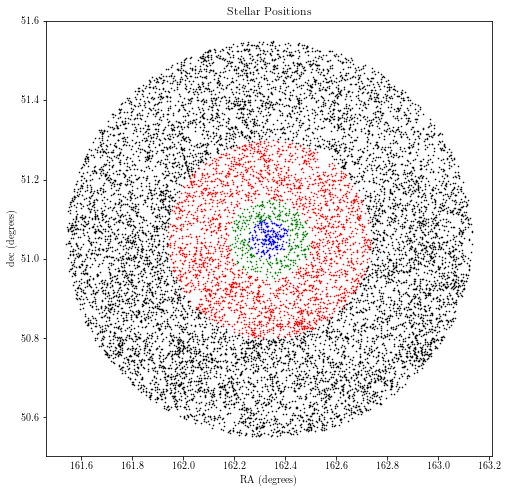

In [26]:
data_dir   = 'fields'        # Directory containing coord_file & all true dwarf fields (.fits).
region_dir = 'regions'
coord_file = 'coords.txt'

field_list = np.genfromtxt(os.path.join(data_dir, coord_file), delimiter='\t', dtype='U32,f8,f8')

# Defines radii (degrees) regions around true dwarf galaxies.
radii = [0.5, 0.25, 0.1, 0.05, 0.025]


for file, ra, dec in field_list:
    hdulist = fits.open(os.path.join(data_dir,file))
    table = hdulist[1].data
    hdulist.close()

    
    #data = imputation(table)
    data    = table
    regions = create_regions(data, ra, dec, radius=(radii[1], radii[2], radii[3]))

    bkg = density(len(regions[0]), radii[0], radii[1])
    num = len(data) - bkg * area(radii[0],0)
    
    print("\n\n---------------{}---------------\n".format(file))
    print("Background Density:\t", str(int(bkg)), "stars per square degree"
          "\nNum Stars in Dwarf:\t", str(int(num)))

    
    for idx in np.arange(4):
        print("\nRegion {}".format(idx+1),
              "\n\tArea:\t", str(area(radii[idx],radii[idx+1])),
              "\n\tPoints:\t", str(len(regions[idx])), "/", str(len(data)),
              "\n\tDensity: ", str(density(len(regions[idx]), radii[idx], radii[idx+1])))
    
    plot_regions(regions, file=file.split('.')[0]+'_regions.pdf', directory=region_dir)
    

## Creating Simulated Fields
### Creating the Background

In [3]:
def background(r, num):
    """
    Samples num pairs of uniformly random variables, centered at 0. between x = [-r,r] and y = [-r,r].
    
    param r:   Half the length of the square sampled.
    param num: Number of randomly generated pairs.
    
    returns ndarray with dimensions (2, num).
    """
    
    return 2 * r * np.transpose(random(size=(num,2)) - 0.5)

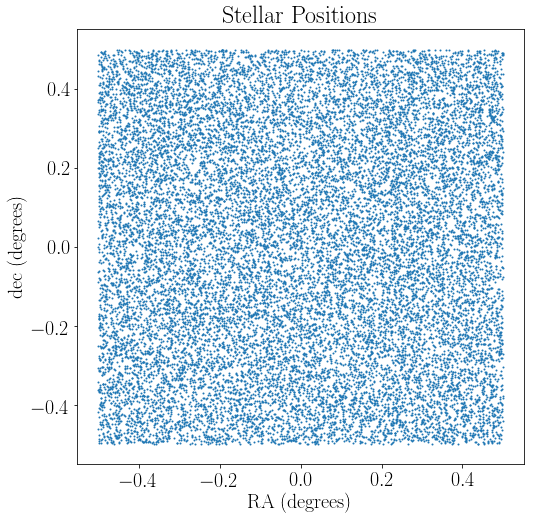

In [5]:
plt.rcParams['savefig.facecolor'] = "1."
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size='20')


position = background(0.5, 20000)

plt.clf()
plt.figure(figsize=(8,8))

plt.xlabel(r"RA (degrees)")
plt.ylabel(r"dec (degrees)")
plt.title(r"Stellar Positions")

plt.scatter(position[0], position[1], s=1.)

### Creating the Dwarf Galaxy

In [7]:
def exponential_profile(scale, num):
    """
    Samples num pairs of exponentially random variables, centered at 0. between x = [-r,r] and y = [-r,r].
    
    param n:   Sersic Index (n=1 is good for spirals and dEs.)
    param num: Number of randomly generated pairs.
    
    returns ndarray with dimensions (2, num).
    """

    r = exponential(scale=scale,size=num)
    theta = 2 * np.pi * random(size=num)
    
    return np.array([r * np.cos(theta), r * np.sin(theta)])

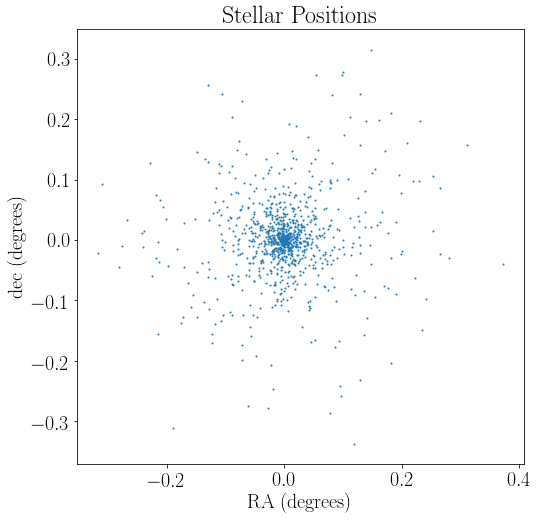

In [8]:
position = exponential_profile(0.07, 1000)

plt.clf()
plt.figure(figsize=(8,8))

plt.xlabel(r"RA (degrees)")
plt.ylabel(r"dec (degrees)")
plt.title(r"Stellar Positions")

plt.scatter(position[0], position[1], s=1.)

### Creating a Binary .fits Table

In [9]:
def create_fits(data, file=None):
    
    if file==None: file = 'file.pdf'
    
    ra  = fits.Column(name='ra',  format='D', unit='deg', array=data[0])
    dec = fits.Column(name='dec', format='D', unit='deg', array=data[1])

    tbhdu = fits.BinTableHDU.from_columns([ra, dec])        
    tbhdu.writeto(file, clobber=True)
    
    return tbhdu

### Creating a Simulated Field

In [10]:
def create_sim(r, dnum, scale, bnum=34000, circ=True, directory='simulated'):

    """
    Generates a Table & Plot of Stars in a Simulated Dwarf Galaxy in a Uniformly Random Background
    
    param r:     Background Radius  --  (r=0.5)
    param dnum:  Number of Stars in the Dwarf Galaxy
    param scale: Scale Length of Dwarf Galaxy
    param bnum:  Number of Point Sources in Pre-Filtered Background per 1 square degree
    
    returns astropy.io.fits Table
    """
    
    create_directory(directory)   
    append = "{}_{}_{}_{}".format(r,dnum,scale,bnum)
    
    # Defines filenames for the .fits files for the dwarf galaxy, the background, the test field,
    #    and a .pdf for the test field.
    plot_file       = os.path.join(directory, "field_{}.pdf".format(append))
    fits_file       = os.path.join(directory, "field_{}.fits".format(append))
    dwarf_file      = os.path.join(directory, "dwarf_{}.fits".format(append))
    background_file = os.path.join(directory, "background_{}.fits".format(append))
    

    # Generates stellar positions for the dwarf and the background, with the dwarf centered in 1 square degree field.
    back  = background(r, bnum)
    dwarf = exponential_profile(scale, dnum)
    
    
    # Executed if the desired field is a circle centered on the dwarf with radius r. 
    if circ:
        # Only keeps the stars in a r=0.5 radius. (Recall original shape is a square.)
        back_filt  = np.array([pair for pair in np.transpose(back) if pair[0]**2 + pair[1]**2 < r**2])
        dwarf_filt = np.array([pair for pair in np.transpose(dwarf) if pair[0]**2 + pair[1]**2 < r**2])
        
        back  = np.transpose(back_filt)
        dwarf = np.transpose(dwarf_filt)

        # The number of stars remaining after filtering
        bnum = np.shape(back_filt)[0]
        dnum = np.shape(dwarf_filt)[0]

    print("Number of Background Sources:\t", bnum)
    print("Number of Stars in Dwarf:\t", dnum)
    
    
    # Creates a astropy.io.fits.Table for background, dwarf, and simulated test field.
    back_table  = create_fits(back, file=background_file)
    dwarf_table = create_fits(dwarf, file=dwarf_file)
    test_table  = create_fits(np.append(back, dwarf, axis=1), file=fits_file)

    # Generates a .pdf plot for the background (black) & the dwarf (red).
    plot_regions([back_table.data, dwarf_table.data], file=plot_file, directory=None)

In [ ]:
r     = 0.5                    # Background Radius
dnum  = [100, 500, 1000, 5000] # Number of Stars in the Dwarf Galaxy
scale = [0.1, 0.15, 0.2]       # Scale Length of Dwarf Galaxy
bnum  = [10000, 15000, 20000]  # Number of Background Point Sources per 1 square degree

for d in dnum:
    for s in scale:
        for b in bnum:
            create_sim(r, d, s, b)

### Examples of Dwarf Galaxies of Various Population Sizes:
(scale=0.15, bnum=15000)

dnum = 100 | 500 | 1000 | 5000
     -     |  -  |  -   |  -
<img src="images/field_0.5_100_0.15_15000.png"> | <img src="images/field_0.5_500_0.15_15000.png"> | <img src="images/field_0.5_1000_0.15_15000.png"> | <img src="images/field_0.5_5000_0.15_15000.png">

### Examples of Dwarf Galaxies of Various Scale Lengths:
(dnum=1000, bnum=15000)

scale = 0.1 | 0.15 | 0.2
      -     |   -  |  -
<img src="images/field_0.5_1000_0.1_15000.png"> | <img src="images/field_0.5_1000_0.15_15000.png"> | <img src="images/field_0.5_1000_0.2_15000.png">

### Examples of Dwarf Galaxies in Various Background Densities:
(dnum=1000, scale=0.15)

bnum = 10000 | 15000 | 20000
     -       |   -   |   -
<img src="images/field_0.5_1000_0.15_10000.png"> | <img src="images/field_0.5_1000_0.15_15000.png"> | <img src="images/field_0.5_1000_0.15_20000.png">

# Applying the Various Density Estimators on Simulated Data

In [38]:
mock_data = ['test_field.fits', 'test_field1.fits']

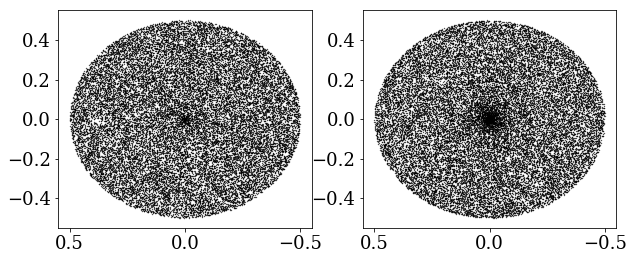

In [46]:
plt.figure(figsize = (10, 4))
k=0
for name in mock_data:
    ra, dec = read_data('../data/mock_fields/'+name)
    plt.subplot2grid((1,2), (0,k))
    
    plt.scatter(ra, dec, c = 'k', s = 0.1)
    plt.gca().invert_xaxis()
    
    k+=1

/Users/ragadeepika.pucha/anaconda/lib/python3.6/site-packages/matplotlib/colorbar.py:215: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")


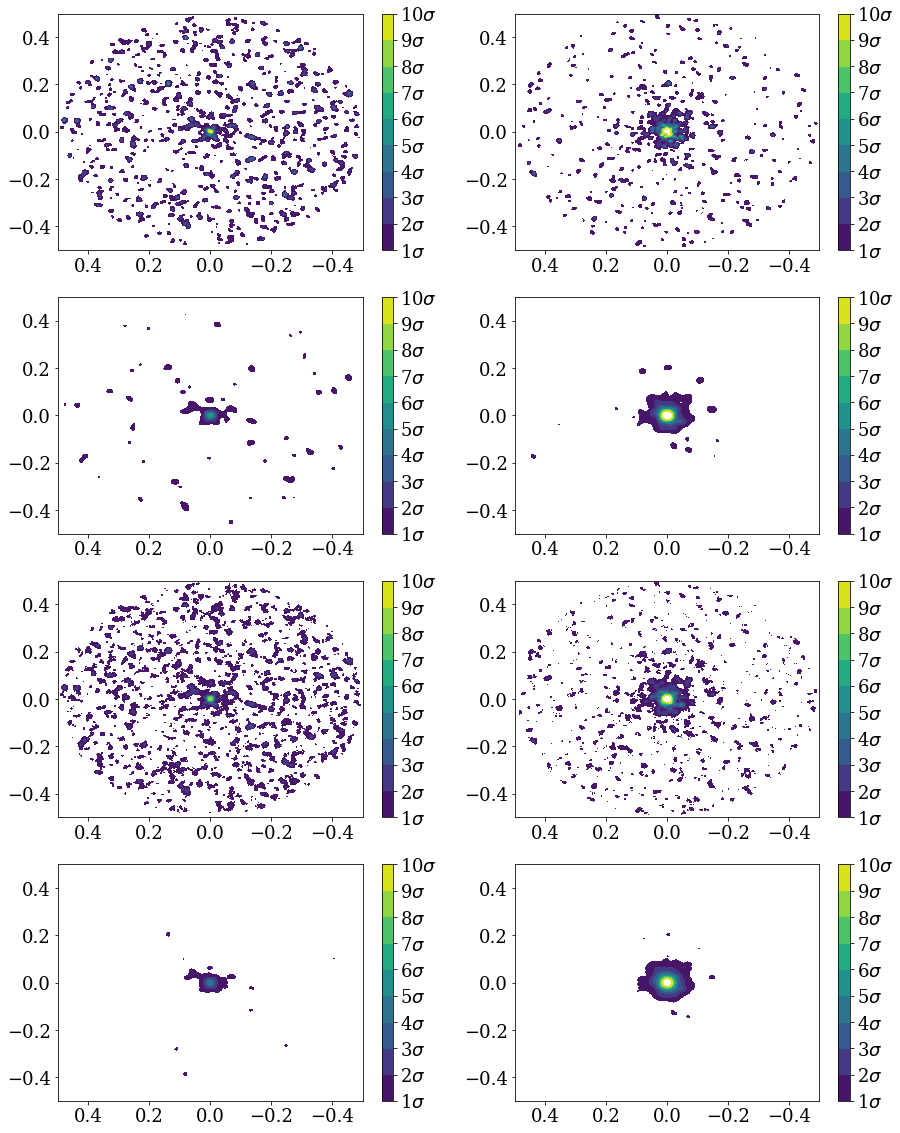

In [42]:
plt.figure(figsize = (15, 20))
k=0

for name in mock_data:
    ra, dec = read_data('../data/mock_fields/'+name)
    dens_field_KDE_exponential = KDE(ra,dec, kernel = 'exponential')
    dens_field_KDE_th = KDE(ra,dec, kernel = 'tophat') 
    dens_field_KDE_gaussian = KDE(ra,dec, kernel = 'gaussian')
    dens_field_NN = NN_bayesian_density(ra, dec, 20, 500)
    
    X_NN, Y_NN, overdens_NN, colorbar_NN = overdensities(dens_field_NN, 1, 10, xmin=min(ra), xmax=max(ra), ymin=min(dec), ymax=max(dec))  
    X_KDE_gaussian, Y_KDE_gaussian, overdens_KDE_gaussian, colorbar_KDE_gauss = overdensities(dens_field_KDE_gaussian, 1, 10, xmin=min(ra), xmax=max(ra), ymin=min(dec), ymax=max(dec))    
    X_KDE_th, Y_KDE_th, overdens_KDE_th, colorbar_KDE_th = overdensities(dens_field_KDE_th, 1, 10, xmin=min(ra), xmax=max(ra), ymin=min(dec), ymax=max(dec))
    X_KDE_exp, Y_KDE_exp, overdens_KDE_exp, colorbar_KDE_exp = overdensities(dens_field_KDE_exponential, 1, 10, xmin=min(ra), xmax=max(ra), ymin=min(dec), ymax=max(dec))    
    
    plt.subplot2grid((4,2), (0, k))
    plt.contourf(X_NN, Y_NN, dens_field_NN, overdens_NN)
    plt.gca().invert_xaxis()
    cbar = plt.colorbar()
    cbar.ax.set_yticks(np.arange(0, len(colorbar_NN)+1, 1))
    cbar.ax.set_yticklabels(colorbar_NN)
    
    plt.subplot2grid((4,2), (1, k))
    plt.contourf(X_KDE_gaussian, Y_KDE_gaussian, dens_field_KDE_gaussian, overdens_KDE_gaussian)
    plt.gca().invert_xaxis()
    cbar = plt.colorbar()
    cbar.ax.set_yticks(np.arange(0, len(colorbar_KDE_gauss)+1, 1))
    cbar.ax.set_yticklabels(colorbar_KDE_gauss)
    
    plt.subplot2grid((4,2), (2, k))
    plt.contourf(X_KDE_th, Y_KDE_th, dens_field_KDE_th, overdens_KDE_th)
    plt.gca().invert_xaxis()
    cbar = plt.colorbar()
    cbar.ax.set_yticks(np.arange(0, len(colorbar_KDE_th)+1, 1))
    cbar.ax.set_yticklabels(colorbar_KDE_th)
    
    plt.subplot2grid((4,2), (3, k))
    plt.contourf(X_KDE_exp, Y_KDE_exp, dens_field_KDE_exponential, overdens_KDE_exp)
    plt.gca().invert_xaxis()
    cbar = plt.colorbar()
    cbar.ax.set_yticks(np.arange(0, len(colorbar_KDE_exp)+1, 1))
    cbar.ax.set_yticklabels(colorbar_KDE_exp)
    k+=1
    

## Two-Point Correlation Functions

$$\xi(R) = \frac{DD-2DR+RR}{RR}$$

Pros:
- Will find any structure in the data, regardless of its shape, density or extent if done correctly.
- Simple to calculate.
- Can be jackknifed to find error bars.

Cons:
- If multiple objects are in the image, the signals will be blended together.
- Requires detailed information about the observing mask.
- Since we are pair counting, it can have very long run times (but can be parallelized easily!).

### Correlation Function with no dwarf

![empty](images/correlationfunction_empty.png)

### Dwarf with no background

![](images/correlationfunction_perfect.png)

### Full simulated field

![](images/correlationfunction_mock.png)

## Conclusions

- The detection efficiency of non-parametric detectors falls with magnitude.
- Running time: Nearest-Neighbor < Top-Hat KDE < Exponential KDE < Gaussian KDE
- All the methods work well on the simulated data.
- The performance of GMM is much less optimum than the non-parametric methods.
- LSST goes much deeper - we will be able to detect more dwarf galaxies (hopefully).